# isocronos desde las universidades de california
#### Una app de voila para visualizar isocronos de las universidades publicas de california.

<details>
    <summary><strong>Meta</strong></summary>
    La meta de este notebook es crear isocronos para la aplicacion de voila.
    <ul>
        <li> Metas mensurables </li>
        <li> Crear el esqueleto de la aplicacion</li>
    </ul>
</details>

<details>
    <summary><strong>Contexto</strong></summary>
    Los datos ya estan limpios y guardados en DATOS_PROCESADOS
</details>

In [23]:
import geopandas as gpd
from zipfile import ZipFile
from pathlib import Path
from herramientas import arbol
import arrow
hoy = arrow.now().format("DD-MMM-YY", locale = 'es')

hoy

'05-jul-19'

In [2]:
DATOS_BRUTOS = Path("../datos/brutos/")
DATOS_INTERINOS = Path("../datos/interinos/")
DATOS_PROCESADOS = Path("../datos/procesados/")
DATOS_EXTERNOS = Path("../datos/externos/")

In [3]:
arbol(DATOS_PROCESADOS)

+ ..\datos\procesados
    + base_de_datos-05-jul-19.csv


In [4]:
datos = pd.read_csv(DATOS_PROCESADOS / 'base_de_datos-05-jul-19.csv', encoding = 'utf-8',)

In [5]:
datos.head()

,Sistema,Nombre,Alias,Nombre (alternativo),Dirección,Ciudad,Código postal,Sitio de internet,Sitio de internet (ayuda financiera),Sitio de internet (oficina de adminsiones),Sitio de internet (aplicación en línea),Dirección OSMNx
0,CCC,Allan Hancock College,NaN,Allan Hancock College,800 South College Drive,Santa Maria,93454-6399,www.hancockcollege.edu/,www.hancockcollege.edu/financial_aid/index.php,www.hancockcollege.edu/admissions_records/,www.hancockcollege.edu/future_students/,"800 South College Drive, Santa Maria 93454-6399"
1,CCC,American River College,American River | ARC,American River College,4700 College Oak Dr,Sacramento,95841-4286,www.arc.losrios.edu/,www.arc.losrios.edu/Support_Services/Financial...,www.arc.losrios.edu/prospective_students.htm,www.losrios.edu/lrc/lrc_app.php,"4700 College Oak Dr, Sacramento 95841-4286"
2,CCC,Antelope Valley College,NaN,Antelope Valley College,3041 West Ave K,Lancaster,93536-5426,www.avc.edu,www.avc.edu/studentservices/finaid/,www.avc.edu/studentservices/adminrec/,www.avc.edu/studentservices/adminrec/applyonline,"3041 West Ave K, Lancaster 93536-5426"
3,CCC,Bakersfield College,NaN,Bakersfield College,1801 Panorama Dr,Bakersfield,93305-1299,www.bakersfieldcollege.edu/,www.bakersfieldcollege.edu/finaid/,www.bakersfieldcollege.edu/admissions/,https://www.bakersfieldcollege.edu/apply,"1801 Panorama Dr, Bakersfield 93305-1299"
4,CCC,Barstow Community College,NaN,Barstow Community College,2700 Barstow Road,Barstow,92311,www.barstow.edu,www.barstow.edu/Financial-Aid.html,www.barstow.edu/Admission-and-Records.html,https://www.opencccapply.net/uPortal/render.us...,"2700 Barstow Road, Barstow 92311"


# Isocronos

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline

In [17]:
# como ejemplo UC Davis donde estudié
mascara_davis = datos['Nombre'].str.contains("Davis")

direccion_davis = datos[mascara_davis]['Dirección OSMNx'].values[0]

direccion_davis

'One Shields Avenue, Davis 95616-8678'

In [18]:
# puede ser
tipo_de_network = "walk"

In [19]:
# en minutos
tiempos = [5, 10, 15, 20, 25]

In [20]:
# velocidad en km/hora
velocidad = 4.5

### Preparación

In [27]:
# Descarga las calles de la ciudad
G = ox.graph_from_place('Davis, CA', network_type = tipo_de_network)

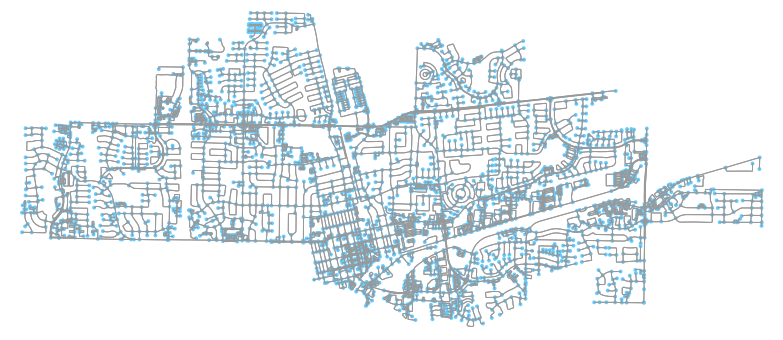

In [30]:
fig, ax = ox.plot_graph(G)

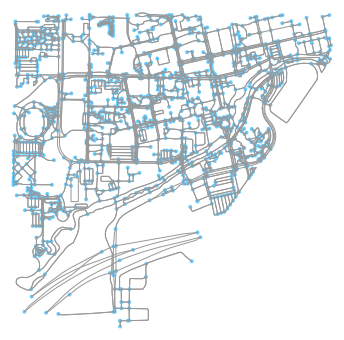

In [42]:
G1 = ox.graph_from_address('Shields Ave, Davis', )
fig, ax = ox.plot_graph(G1)

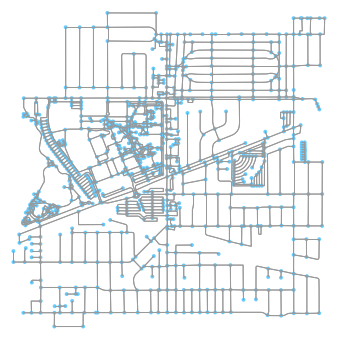

In [45]:
g2 = ox.graph_from_address(direcciones[55], network_type = tipo_de_network)
fig, ax = ox.plot_graph(g2)

In [71]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(g2, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(g2, (y[0], x[0]))
g2 = ox.project_graph(g2)

In [72]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = velocidad * 1000 / 60 #km per hour to m per minute
for u, v, k, data in g2.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [73]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(tiempos), cmap='Reds', start=0.3, return_hex=True)

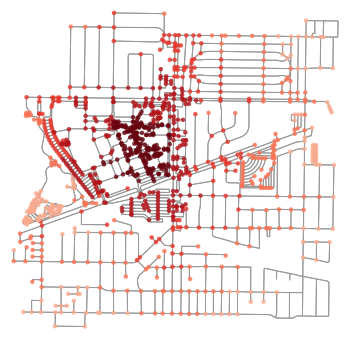

In [74]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(tiempos, reverse=True), iso_colors):
    subgraph = nx.ego_graph(g2, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in g2.nodes()]
ns = [20 if node in node_colors else 0 for node in g2.nodes()]
fig, ax = ox.plot_graph(g2, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [84]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False, trip_times = [5, 10, 15, 20, 25, 30,]):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lines.append(LineString([f,t]))

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

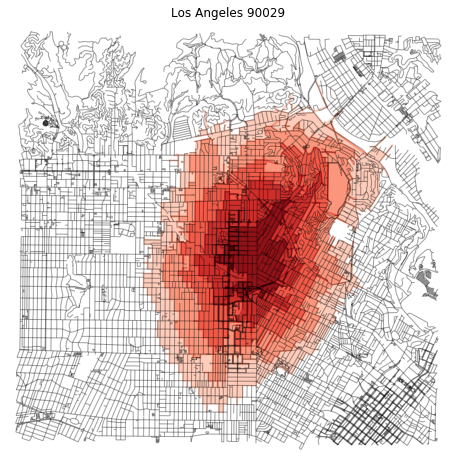

In [86]:
G = ox.graph_from_address(direcciones[75], distance = 5000, network_type = "walk")

# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
    
plt.title(direcciones[75].split(", ")[-1])
plt.show()